# Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Data

In [3]:
# levantamos los datos
df = pd.read_csv('podcast_dataset.csv')

# peek
df.head()

,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes
0,Healthy Living,Episode 77,99.25,Health,21.37,Thursday,Night,70.22,3,Positive,55.158695
1,Mystery Matters,Episode 6,19.43,True Crime,47.19,Friday,Evening,75.15,1,Neutral,7.686559
2,Current Affairs,Episode 1,117.03,News,96.33,Sunday,Night,57.95,3,Neutral,110.064645
3,Mystery Matters,Episode 38,16.97,True Crime,25.73,Monday,Night,24.19,0,Positive,12.000380
4,Humor Hub,Episode 73,83.48,Comedy,76.69,Tuesday,Afternoon,42.31,3,Positive,NaN


# Preprocessing

Ver notebook de EDA.

In [4]:
# drop duplicates
df.drop_duplicates(inplace=True)

# target relativo
df['fraction_listened'] = df['Listening_Time_minutes'] / df['Episode_Length_minutes']

# encoding de episode number
df['Episode_Number'] = df['Episode_Title'].apply(lambda x: x.split(" ")[-1]).astype(int)

# ausencia de guest
df['no_guest'] = df['Guest_Popularity_percentage'].isna()

# imputacion de NaNs
df.fillna({'Guest_Popularity_percentage':-1}, inplace=True)

# dropeo de NaNs de las otras columnas y reseteo de index
df.dropna(inplace=True)
df.reset_index(inplace=True, drop=True)

# encoding de sentiment
df['sentiment_encoded'] = df['Episode_Sentiment'].map({'Neutral':0, 'Negative':-1, 'Positive':1}).astype(int)

# drop de variables ahora redundantes
df.drop(columns=['Episode_Title', 'Episode_Sentiment'], inplace=True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40374 entries, 0 to 40373
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Podcast_Name                 40374 non-null  object 
 1   Episode_Length_minutes       40374 non-null  float64
 2   Genre                        40374 non-null  object 
 3   Host_Popularity_percentage   40374 non-null  float64
 4   Publication_Day              40374 non-null  object 
 5   Publication_Time             40374 non-null  object 
 6   Guest_Popularity_percentage  40374 non-null  float64
 7   Number_of_Ads                40374 non-null  int64  
 8   Listening_Time_minutes       40374 non-null  float64
 9   fraction_listened            40374 non-null  float64
 10  Episode_Number               40374 non-null  int64  
 11  no_guest                     40374 non-null  bool   
 12  sentiment_encoded            40374 non-null  int64  
dtypes: bool(1), floa

# Baseline

Para este problema elegimos minimizar el MSE/RMSE, aunque también miramos el MAE.

In [6]:
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error
from sklearn.preprocessing import OneHotEncoder, TargetEncoder
#from category_encoders import TargetEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer
from tqdm import tqdm

In [7]:
X = df.drop(columns=['Listening_Time_minutes','fraction_listened'])
y_abs = df['Listening_Time_minutes']
y_rel = df['fraction_listened']

In [8]:
numeric_cols = X.columns[X.dtypes!='object'].tolist()
numeric_cols

['Episode_Length_minutes',
 'Host_Popularity_percentage',
 'Guest_Popularity_percentage',
 'Number_of_Ads',
 'Episode_Number',
 'no_guest',
 'sentiment_encoded']

In [9]:
cat_cols = X.columns[X.dtypes=='object'].tolist()
cat_cols

['Podcast_Name', 'Genre', 'Publication_Day', 'Publication_Time']

In [10]:
# utils
def rel_to_abs(y_pred_rel, X):
    return y_pred_rel * X['Episode_Length_minutes']

METRICS = {
    'mae': mean_absolute_error,
    'mse': mean_squared_error,
    'rmse': root_mean_squared_error,
}

SPLITTER = KFold(n_splits=5, random_state=42, shuffle=True)

def cv_model(model_constructor_f, X, is_rel, model_args={}):
    results = []
    models = []
    for i, (train_idx, test_idx) in tqdm(enumerate(SPLITTER.split(X)), 
                                         total=SPLITTER.get_n_splits()):
        X_train = X.loc[train_idx]
        X_test = X.loc[test_idx]

        y_train = y_rel[train_idx] if is_rel else y_abs[train_idx]
        y_test = y_abs[test_idx]

        # inst+fit model
        model = model_constructor_f(**model_args)

        model.fit(X_train, y_train)

        # predict
        y_pred = model.predict(X_test)

        # if rel, adjust to abs
        if is_rel:
            y_pred = rel_to_abs(y_pred, X_test)

        results.append({name:f(y_test, y_pred) for name,f in METRICS.items()})
        models.append(model)

    res_df = pd.DataFrame(results)
    # add mean and std values across folds for all metrics
    return pd.concat((res_df, res_df.describe().loc[['mean','std']])), models

In [11]:
# gráfico de importancias across-folds
# utils
def lr_weights(
        models: Pipeline | LinearRegression | list[Pipeline] | list[LinearRegression],
        feature_names: list[str],
        horizontal: bool = True,
        seed: int = 1234) -> None:
    if not isinstance(models, list):
        models = [models]
    if isinstance(models[0], Pipeline):
        models = [model[-1] for model in models]
    coefs = np.vstack([np.concatenate([*x.coef_, x.intercept_]) for x in models])
    df = pd.DataFrame(coefs, columns=feature_names+['intercept'])
    ax = sns.barplot(df, orient='h' if horizontal else 'v', seed=seed)
    ax.set_title(f"LR coefficients across evaluation procedure")
    plt.show()

def rf_importance(
        models: Pipeline | RandomForestRegressor | list[RandomForestRegressor] | list[Pipeline],
        feature_names: list[str],
        horizontal: bool = True,
        seed: int = 1234) -> None:
    if not isinstance(models, list):
        models = [models]
    if isinstance(models[0], Pipeline):
        models = [model[-1] for model in models]
    df_importances = pd.DataFrame([model.feature_importances_ for model in models], columns=feature_names)
    ax = sns.barplot(df_importances, orient='h' if horizontal else 'v', seed=seed)
    ax.set_title(f"RF feature importances across evaluation procedure")
    plt.show()

## Sobre target absoluto

In [12]:
X_only_numeric = X[numeric_cols]
X_only_numeric

,Episode_Length_minutes,Host_Popularity_percentage,Guest_Popularity_percentage,Number_of_Ads,Episode_Number,no_guest,sentiment_encoded
0,99.25,21.37,70.22,3,77,False,1
1,19.43,47.19,75.15,1,6,False,0
2,117.03,96.33,57.95,3,1,False,0
3,16.97,25.73,24.19,0,38,False,1
4,28.06,22.02,-1.00,1,87,True,0
...,...,...,...,...,...,...,...
40369,92.44,27.34,63.54,3,77,False,1
40370,50.30,20.61,55.63,0,100,False,1
40371,89.78,93.08,93.12,3,12,False,1
40372,77.86,41.04,52.33,2,18,False,1


In [13]:
res_rf_abs, models_rf_abs = cv_model(
    lambda **kwargs: RandomForestRegressor(**kwargs), 
    X=X_only_numeric,
    is_rel=False,
    model_args=dict(n_jobs=-1)
)

100%|██████████| 5/5 [00:16<00:00,  3.34s/it]


In [14]:
res_rf_abs

,mae,mse,rmse
0,9.080261,134.808166,11.610692
1,8.916633,131.225870,11.455386
2,8.977923,132.681210,11.518733
3,8.959239,131.839199,11.482125
4,9.039554,133.462102,11.552580
mean,8.994722,132.803309,11.523903
std,0.065127,1.404118,0.060871


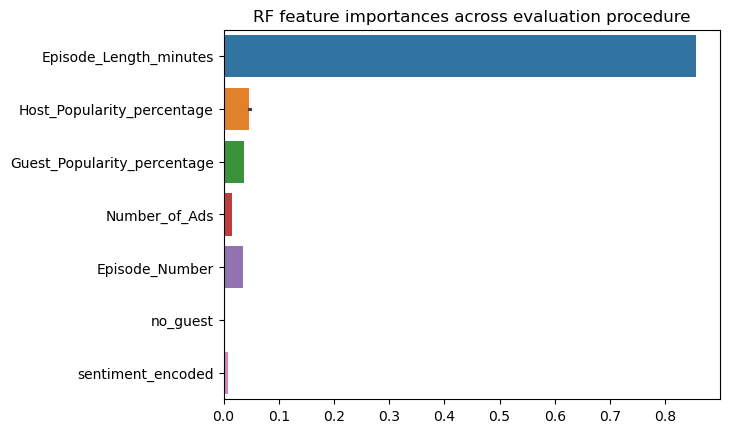

In [15]:
rf_importance(models_rf_abs, X_only_numeric.columns)

## Sobre target relativo

In [16]:
res_rf_rel, models_rf_rel = cv_model(
    lambda **kwargs: RandomForestRegressor(**kwargs), 
    X=X_only_numeric,
    is_rel=True,
    model_args=dict(n_jobs=-1)
)

100%|██████████| 5/5 [00:23<00:00,  4.66s/it]


In [17]:
res_rf_rel

,mae,mse,rmse
0,9.089299,134.377014,11.592110
1,8.864314,129.608171,11.384558
2,8.957448,132.034834,11.490641
3,8.988458,132.402524,11.506630
4,9.061478,133.633322,11.559988
mean,8.992199,132.411173,11.506785
std,0.089169,1.827341,0.079547


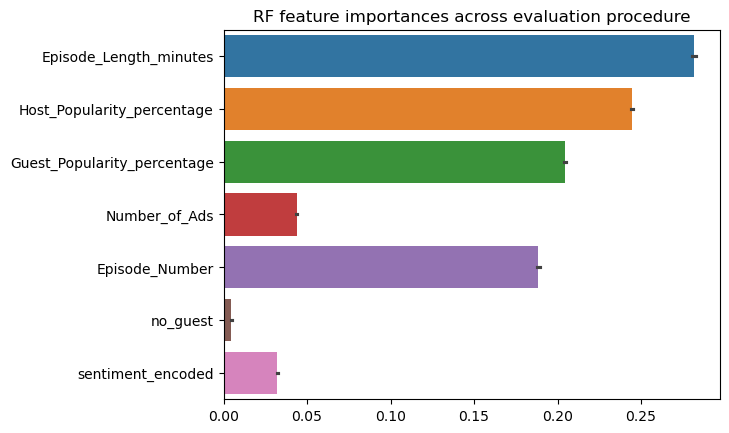

In [18]:
rf_importance(models_rf_rel, X_only_numeric.columns)

Se observa que la diferencia en performance entre usar target relativo y absoluto es mínima, aunque favorece levemente al target relativo.

Sin embargo, debe destacarse que el modelo con target relativo utiliza mucho mejor las diferentes features, mientras que el absoluto se concentra casi exclusivamente en la duración del podcast.

# Baseline + variables categóricas

## One Hot Encoding

In [19]:
res_onehot_rel, models_onehot_rel = cv_model(
    lambda : make_pipeline(
        make_column_transformer(
            ('passthrough',numeric_cols),
            (OneHotEncoder(sparse_output=False), cat_cols),
            sparse_threshold=0,
            n_jobs=-1
        ),
        RandomForestRegressor(n_jobs=-1)
    ),
    X=X,
    is_rel=True
)

100%|██████████| 5/5 [00:47<00:00,  9.42s/it]


In [20]:
res_onehot_rel

,mae,mse,rmse
0,8.991037,131.078403,11.448948
1,8.839595,127.001257,11.269483
2,8.849904,128.423729,11.332419
3,8.871858,127.787229,11.304301
4,8.909350,128.798851,11.348958
mean,8.892349,128.617894,11.340822
std,0.061304,1.535258,0.067548


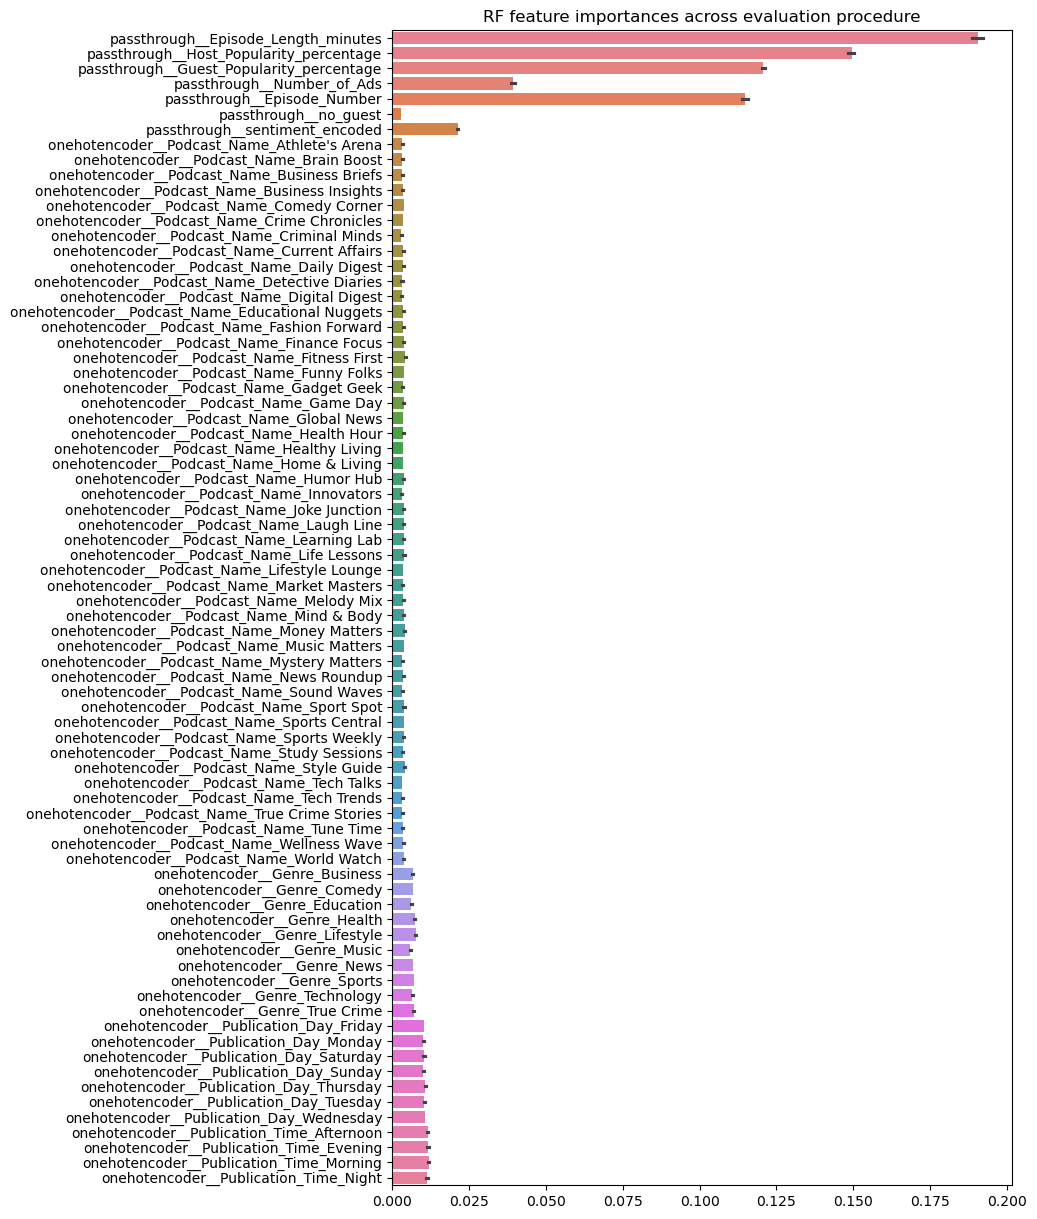

<Figure size 640x480 with 0 Axes>

In [21]:
fig, ax = plt.subplots(figsize=(8,15))
rf_importance(models_onehot_rel, models_onehot_rel[0][-2].get_feature_names_out())
plt.tight_layout()

## Target Encoding

In [22]:
res_tgt_rel, models_tgt_rel = cv_model(
    lambda : make_pipeline(
        make_column_transformer(
            ('passthrough',numeric_cols),
            (TargetEncoder(target_type='continuous', random_state=42), cat_cols),
            sparse_threshold=0,
            n_jobs=-1
        ),
        RandomForestRegressor(n_jobs=-1)
    ),
    X=X,
    is_rel=True
)

100%|██████████| 5/5 [00:28<00:00,  5.62s/it]


In [23]:
res_tgt_rel

,mae,mse,rmse
0,8.963959,129.964385,11.400192
1,8.827792,127.102944,11.273994
2,8.851782,127.604881,11.296233
3,8.838532,125.867896,11.219086
4,8.894045,127.440231,11.288943
mean,8.875222,127.596068,11.295690
std,0.055619,1.488543,0.065775


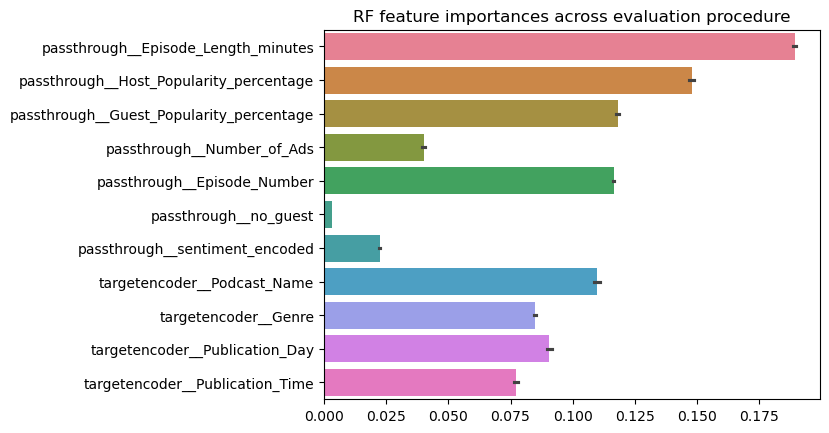

In [24]:
rf_importance(models_tgt_rel, models_tgt_rel[0][-2].get_feature_names_out())

Como se puede observar, la performance de las categorías encodeadas vía Target Encoding es superior a la de One Hot Encoding, incluso para aquellas de baja cardinalidad. Cabe destacar que el Target Encoder tiene hiperparámetros que no han sido tuneados, se están utilizando los default.

# Feature Engineering

In [25]:
# Comentado porque hay un error.

"""# cantidad media de ads por minuto 
X['ad_density'] = X['Number_of_Ads'] / X['Episode_Length_minutes']

# popularidad sumada de Host y Guest
X['joint_popularity'] = X['Host_Popularity_percentage'] + X['Guest_Popularity_percentage']

# como son pocas categóricas, se pueden hacer combinaciones y luego encodearlas por algún tipo de target encoding
for n in range(2,len(cat_cols)+1):
    for cols in combinations(cat_cols,n):
        cols_list = list(cols) # pandas gets angry if they're tuples instead of lists
        X[f"comb_{n}_"+"+".join(cols)] = X[cols_list].apply(lambda s: '-'.join(s), axis=1)"""

'# cantidad media de ads por minuto \nX[\'ad_density\'] = X[\'Number_of_Ads\'] / X[\'Episode_Length_minutes\']\n\n# popularidad sumada de Host y Guest\nX[\'joint_popularity\'] = X[\'Host_Popularity_percentage\'] + X[\'Guest_Popularity_percentage\']\n\n# como son pocas categóricas, se pueden hacer combinaciones y luego encodearlas por algún tipo de target encoding\nfor n in range(2,len(cat_cols)+1):\n    for cols in combinations(cat_cols,n):\n        cols_list = list(cols) # pandas gets angry if they\'re tuples instead of lists\n        X[f"comb_{n}_"+"+".join(cols)] = X[cols_list].apply(lambda s: \'-\'.join(s), axis=1)'

In [26]:
comb_cols = X.columns[X.columns.str.startswith('comb_')].tolist()

In [27]:
# a ver como se ve
X.head().T

,0,1,2,3,4
Podcast_Name,Healthy Living,Mystery Matters,Current Affairs,Mystery Matters,Money Matters
Episode_Length_minutes,99.25,19.43,117.03,16.97,28.06
Genre,Health,True Crime,News,True Crime,Business
Host_Popularity_percentage,21.37,47.19,96.33,25.73,22.02
Publication_Day,Thursday,Friday,Sunday,Monday,Wednesday
Publication_Time,Night,Evening,Night,Night,Morning
Guest_Popularity_percentage,70.22,75.15,57.95,24.19,-1.0
Number_of_Ads,3,1,3,0,1
Episode_Number,77,6,1,38,87
no_guest,False,False,False,False,True


Probamos su importancia utilizando un Random Forest con Target Encoding y valores default como antes.

In [28]:
res_fe_rel, models_fe_rel = cv_model(
    lambda : make_pipeline(
        make_column_transformer(
            ('passthrough',X.columns[X.dtypes != 'object']),
            (TargetEncoder(target_type='continuous', random_state=42), cat_cols+comb_cols),
            sparse_threshold=0,
            n_jobs=-1
        ),
        RandomForestRegressor(n_jobs=-1)
    ),
    X=X,
    is_rel=True
)

100%|██████████| 5/5 [00:28<00:00,  5.73s/it]


In [29]:
res_fe_rel

,mae,mse,rmse
0,8.955216,129.828921,11.394249
1,8.824645,126.887694,11.264444
2,8.839973,127.648398,11.298159
3,8.819407,125.228369,11.190548
4,8.918955,128.274183,11.325819
mean,8.871639,127.573513,11.294644
std,0.061570,1.699519,0.075255


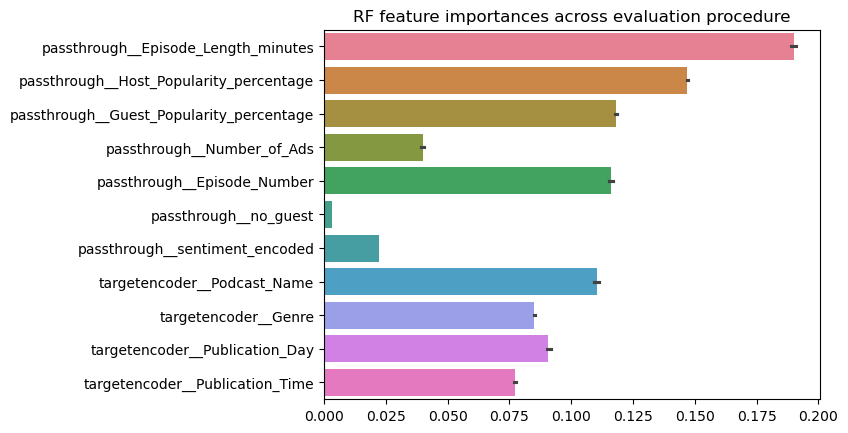

In [30]:
rf_importance(models_fe_rel, models_fe_rel[0][-2].get_feature_names_out())

Como se puede apreciar, con las nuevas variables el RMSE baja de 11.31 a 11.23 y el MAE de 8.88 a 8.83 (en media sobre 5 folds). Además la importancia de las variables es bastante alta y con poca variabilidad entre folds, lo que indica que tienen poder predictivo.

Por completitud se estima la performance utilizando target absoluto:

In [31]:
res_fe_abs, models_fe_abs = cv_model(
    lambda : make_pipeline(
        make_column_transformer(
            ('passthrough',X.columns[X.dtypes != 'object']),
            (TargetEncoder(target_type='continuous', random_state=42), cat_cols+comb_cols),
            sparse_threshold=0,
            n_jobs=-1
        ),
        RandomForestRegressor(n_jobs=-1)
    ),
    X=X,
    is_rel=False
)

res_fe_abs

100%|██████████| 5/5 [00:23<00:00,  4.74s/it]


,mae,mse,rmse
0,8.985101,131.138205,11.451559
1,8.860642,127.862395,11.307626
2,8.856261,128.351450,11.329230
3,8.923277,128.820579,11.349915
4,8.957220,130.199527,11.410501
mean,8.916500,129.274432,11.369766
std,0.057357,1.358416,0.059683


Como era de esperarse, la performance es peor. Se confirma entonces qeu es mejor utilizar el target relativo.

# Testeo de diferentes modelos

**TO DO PROBAR DIFERENTES MODELOS CON VALORES DEFAULT**

* Ridge
* LASSO
* SVR
* LightGBM (probablemente el que mejor ande, probar usando su propio encoding en vez del Tgt Enc)

In [32]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import make_pipeline

def make_preprocessed_pipeline(model, numeric_cols, cat_cols):
    preprocessor = make_column_transformer(
        ('passthrough', numeric_cols),
        (OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols),
        remainder='drop',
        sparse_threshold=0,
    )
    
    return make_pipeline(preprocessor, StandardScaler(), model)

In [33]:
from sklearn.linear_model import Lasso, Ridge
res_lasso_rel, models_lasso_rel = cv_model(
    lambda: make_preprocessed_pipeline(Lasso(alpha=0.1), numeric_cols, cat_cols),
    X=X,
    is_rel=True
)

100%|██████████| 5/5 [00:01<00:00,  3.06it/s]


In [34]:
res_lasso_rel

,mae,mse,rmse
0,9.209609,140.167239,11.839225
1,9.085107,136.077064,11.665207
2,9.125548,137.878952,11.742187
3,9.181672,137.886407,11.742504
4,9.198843,138.803393,11.781485
mean,9.160156,138.162611,11.754122
std,0.052998,1.494607,0.063589


In [35]:
res_ridge_rel, models_ridge_rel = cv_model(
    lambda: make_preprocessed_pipeline(Ridge(alpha=1.0), numeric_cols, cat_cols),
    X=X,
    is_rel=True
)

100%|██████████| 5/5 [00:02<00:00,  2.26it/s]


In [36]:
res_ridge_rel

,mae,mse,rmse
0,8.877918,126.952204,11.267307
1,8.752063,123.962696,11.133854
2,8.804853,125.246857,11.191374
3,8.796154,124.144580,11.142019
4,8.856516,125.605072,11.207367
mean,8.817501,125.182282,11.188384
std,0.050175,1.212411,0.054133


In [37]:
from sklearn.svm import SVR
# Comentado porque demora mucho tiempo (algunos minutos)
"""res_svr_rel, models_svr_rel = cv_model(
    lambda: make_preprocessed_pipeline(SVR(C=1.0, epsilon=0.1), numeric_cols, cat_cols),
    X=X,
    is_rel=True
)

res_svr_rel"""

'res_svr_rel, models_svr_rel = cv_model(\n    lambda: make_preprocessed_pipeline(SVR(C=1.0, epsilon=0.1), numeric_cols, cat_cols),\n    X=X,\n    is_rel=True\n)\n\nres_svr_rel'

In [38]:
# ejemplo de LightGBM
from lightgbm import LGBMRegressor

X_cats = X.copy()

for col in cat_cols+comb_cols:
    X_cats[col] = X_cats[col].astype("category")

X_cats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40374 entries, 0 to 40373
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   Podcast_Name                 40374 non-null  category
 1   Episode_Length_minutes       40374 non-null  float64 
 2   Genre                        40374 non-null  category
 3   Host_Popularity_percentage   40374 non-null  float64 
 4   Publication_Day              40374 non-null  category
 5   Publication_Time             40374 non-null  category
 6   Guest_Popularity_percentage  40374 non-null  float64 
 7   Number_of_Ads                40374 non-null  int64   
 8   Episode_Number               40374 non-null  int64   
 9   no_guest                     40374 non-null  bool    
 10  sentiment_encoded            40374 non-null  int64   
dtypes: bool(1), category(4), float64(3), int64(3)
memory usage: 2.0 MB


In [39]:
res_lgb_rel, models_lgb_rel = cv_model(
    lambda : LGBMRegressor(num_leaves=31, max_bin=2048, subsample=1., subsample_freq=8, colsample_bytree=0.9),
    X=X_cats,
    is_rel=True
)

  0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001685 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6323
[LightGBM] [Info] Number of data points in the train set: 32299, number of used features: 11
[LightGBM] [Info] Start training from score 0.713479


 20%|██        | 1/5 [00:00<00:01,  2.32it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002162 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6322
[LightGBM] [Info] Number of data points in the train set: 32299, number of used features: 11
[LightGBM] [Info] Start training from score 0.713263


 40%|████      | 2/5 [00:00<00:01,  2.75it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000877 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6321
[LightGBM] [Info] Number of data points in the train set: 32299, number of used features: 11
[LightGBM] [Info] Start training from score 0.712785


 60%|██████    | 3/5 [00:01<00:00,  3.12it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001077 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6323
[LightGBM] [Info] Number of data points in the train set: 32299, number of used features: 11
[LightGBM] [Info] Start training from score 0.713100


 80%|████████  | 4/5 [00:01<00:00,  3.50it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001473 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6324
[LightGBM] [Info] Number of data points in the train set: 32300, number of used features: 11
[LightGBM] [Info] Start training from score 0.712298


100%|██████████| 5/5 [00:01<00:00,  3.29it/s]


In [40]:
res_lgb_rel

,mae,mse,rmse
0,8.875132,126.298831,11.238275
1,8.701733,122.375952,11.062366
2,8.737425,123.231458,11.100967
3,8.729361,122.194616,11.054167
4,8.807115,124.648173,11.164595
mean,8.770153,123.749806,11.124074
std,0.070362,1.723323,0.077318


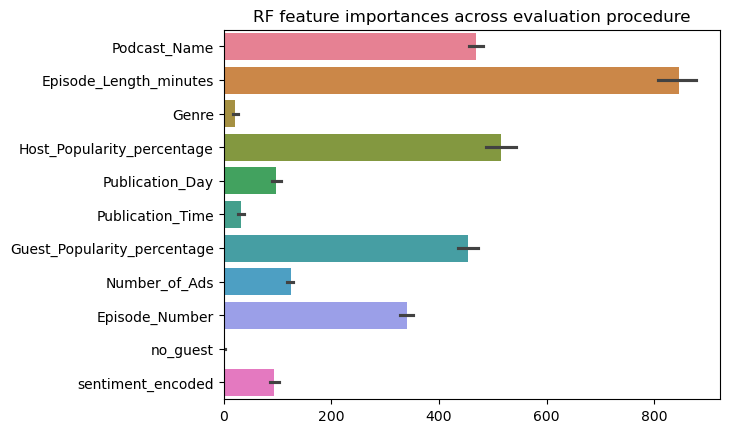

In [41]:
rf_importance(models_lgb_rel, X_cats.columns)

Parece que anda mal por insistencia en concentrarse en las mismas features, tal vez por eso anda mejor el RF? Ver los demás.


**TO DO HACER MINI FEATURE SELECTION Y HP TUNING SI ES POSIBLE CON OPTUNA Y W&B**

In [42]:
import optuna
import tqdm as notebook_tqdm

def objective_random_forest(trial):
    #n_estimators = trial.suggest_int('n_estimators', 50, 200)
    #max_depth = trial.suggest_int('max_depth', 2, 20)
    #min_samples_split = trial.suggest_int('min_samples_split', 2, 10)

    n_estimators = trial.suggest_int('n_estimators', 50, 100) 
    max_depth = trial.suggest_int('max_depth', 3, 6)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)

    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        random_state=42,
        n_jobs=-1
    )

    pipeline = make_preprocessed_pipeline(model, numeric_cols, cat_cols)

    score, _ = cv_model(
        lambda: pipeline,
        X=X,
        is_rel=True
    )

    return score['rmse'].mean()

# Descomentar para ejecutar la optimización sin W&B
#study = optuna.create_study(direction="minimize") 
#study.optimize(objective_random_forest, n_trials=10)

/usr/lib/python3/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
import wandb
wandb.login()

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/gustavo/.netrc
wandb: Currently logged in as: gustavoramoscelli (gustavoramoscelli-universidad-nacional-del-sur) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [44]:
from optuna.integration.wandb import WeightsAndBiasesCallback

wandb_kwargs = {
    "project": "optuna-rf", 
    "name": "random-forest-optimization" 
}
wandbc = WeightsAndBiasesCallback(wandb_kwargs=wandb_kwargs, as_multirun=False)

study = optuna.create_study(direction="minimize")
study.optimize(objective_random_forest, n_trials=10, callbacks=[wandbc])


/tmp/ipykernel_578407/4056802623.py:7: ExperimentalWarning: WeightsAndBiasesCallback is experimental (supported from v2.9.0). The interface can change in the future.
  wandbc = WeightsAndBiasesCallback(wandb_kwargs=wandb_kwargs, as_multirun=False)


[I 2025-04-24 05:31:27,379] A new study created in memory with name: no-name-ca39ad5b-e41a-44df-8dc1-87e4d38b7c1f
100%|██████████| 5/5 [00:11<00:00,  2.23s/it]
[I 2025-04-24 05:31:38,534] Trial 0 finished with value: 9.521021277848321 and parameters: {'n_estimators': 86, 'max_depth': 5, 'min_samples_split': 8}. Best is trial 0 with value: 9.521021277848321.
100%|██████████| 5/5 [00:08<00:00,  1.65s/it]
[I 2025-04-24 05:31:46,806] Trial 1 finished with value: 9.626179525464973 and parameters: {'n_estimators': 82, 'max_depth': 3, 'min_samples_split': 3}. Best is trial 0 with value: 9.521021277848321.
100%|██████████| 5/5 [00:07<00:00,  1.59s/it]
[I 2025-04-24 05:31:54,765] Trial 2 finished with value: 9.559427660360925 and parameters: {'n_estimators': 63, 'max_depth': 4, 'min_samples_split': 8}. Best is trial 0 with value: 9.521021277848321.
100%|██████████| 5/5 [00:11<00:00,  2.35s/it]
[I 2025-04-24 05:32:06,516] Trial 3 finished with value: 9.521000119507217 and parameters: {'n_estimat

In [45]:
print("Mejores parámetros:", study.best_params)
print("Mejor valor de la métrica (RMSE):", study.best_value)

Mejores parámetros: {'n_estimators': 85, 'max_depth': 6, 'min_samples_split': 4}
Mejor valor de la métrica (RMSE): 9.509539954348783


In [46]:
from sklearn.ensemble import GradientBoostingRegressor

def objective_gradient_boosting(trial):
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)
    n_estimators = trial.suggest_int('n_estimators', 50, 100)
    max_depth = trial.suggest_int('max_depth', 3, 6)

    model = GradientBoostingRegressor(
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        max_depth=max_depth,
        random_state=42
    )

    pipeline = make_preprocessed_pipeline(model, numeric_cols, cat_cols)
    score, _ = cv_model(lambda: pipeline, X=X, is_rel=True)

    return score['rmse'].mean()


In [47]:
wandb_kwargs = {
    "project": "optuna-gbr", 
    "name": "gradient-boosting-optimization"
}

wandbc = WeightsAndBiasesCallback(wandb_kwargs=wandb_kwargs, as_multirun=True)

study = optuna.create_study(direction="minimize")
study.optimize(objective_gradient_boosting, n_trials=10, callbacks=[wandbc])

/tmp/ipykernel_578407/636689585.py:6: ExperimentalWarning: WeightsAndBiasesCallback is experimental (supported from v2.9.0). The interface can change in the future.
  wandbc = WeightsAndBiasesCallback(wandb_kwargs=wandb_kwargs, as_multirun=True)
[I 2025-04-24 05:33:09,590] A new study created in memory with name: no-name-6bacb3c1-ee48-4c9d-a292-397fb95688c7
100%|██████████| 5/5 [01:09<00:00, 13.87s/it]
[I 2025-04-24 05:34:18,959] Trial 0 finished with value: 9.561180072376416 and parameters: {'learning_rate': 0.23567871532796847, 'n_estimators': 88, 'max_depth': 5}. Best is trial 0 with value: 9.561180072376416.


max_depth,▆▁▃▆▆▁█▃█▆
min_samples_split,▆▁▆▃▃▁▃▄▂█
n_estimators,▆▆▃▇█▃▁▇▆█
value,▂█▄▂▂█▁▄▁▂
max_depth,5
min_samples_split,10
n_estimators,97
value,9.52084


100%|██████████| 5/5 [00:53<00:00, 10.74s/it]
[I 2025-04-24 05:35:15,167] Trial 1 finished with value: 9.512027757363304 and parameters: {'learning_rate': 0.12448008811712255, 'n_estimators': 68, 'max_depth': 5}. Best is trial 1 with value: 9.512027757363304.


learning_rate,▁
max_depth,▁
n_estimators,▁
trial_number,▁
value,▁
learning_rate,0.12448
max_depth,5
n_estimators,68
trial_number,1
value,9.51203


100%|██████████| 5/5 [01:08<00:00, 13.71s/it]
[I 2025-04-24 05:36:27,712] Trial 2 finished with value: 9.578934029585083 and parameters: {'learning_rate': 0.21394285687475734, 'n_estimators': 73, 'max_depth': 6}. Best is trial 1 with value: 9.512027757363304.


learning_rate,▁
max_depth,▁
n_estimators,▁
trial_number,▁
value,▁
learning_rate,0.21394
max_depth,6
n_estimators,73
trial_number,2
value,9.57893


100%|██████████| 5/5 [00:35<00:00,  7.10s/it]
[I 2025-04-24 05:37:07,767] Trial 3 finished with value: 9.49304842253584 and parameters: {'learning_rate': 0.11112347006793524, 'n_estimators': 57, 'max_depth': 4}. Best is trial 3 with value: 9.49304842253584.


learning_rate,▁
max_depth,▁
n_estimators,▁
trial_number,▁
value,▁
learning_rate,0.11112
max_depth,4
n_estimators,57
trial_number,3
value,9.49305


100%|██████████| 5/5 [00:46<00:00,  9.25s/it]
[I 2025-04-24 05:37:58,344] Trial 4 finished with value: 9.493525700245257 and parameters: {'learning_rate': 0.07683914484213462, 'n_estimators': 97, 'max_depth': 3}. Best is trial 3 with value: 9.49304842253584.


learning_rate,▁
max_depth,▁
n_estimators,▁
trial_number,▁
value,▁
learning_rate,0.07684
max_depth,3
n_estimators,97
trial_number,4
value,9.49353


100%|██████████| 5/5 [00:58<00:00, 11.72s/it]
[I 2025-04-24 05:39:00,570] Trial 5 finished with value: 9.531919944157815 and parameters: {'learning_rate': 0.1687880391461053, 'n_estimators': 75, 'max_depth': 5}. Best is trial 3 with value: 9.49304842253584.


learning_rate,▁
max_depth,▁
n_estimators,▁
trial_number,▁
value,▁
learning_rate,0.16879
max_depth,5
n_estimators,75
trial_number,5
value,9.53192


100%|██████████| 5/5 [01:09<00:00, 13.91s/it]
[I 2025-04-24 05:40:13,993] Trial 6 finished with value: 9.57838543931958 and parameters: {'learning_rate': 0.2622831299467737, 'n_estimators': 89, 'max_depth': 5}. Best is trial 3 with value: 9.49304842253584.


learning_rate,▁
max_depth,▁
n_estimators,▁
trial_number,▁
value,▁
learning_rate,0.26228
max_depth,5
n_estimators,89
trial_number,6
value,9.57839


100%|██████████| 5/5 [00:46<00:00,  9.34s/it]
[I 2025-04-24 05:41:04,588] Trial 7 finished with value: 9.581124584189794 and parameters: {'learning_rate': 0.2786739260878531, 'n_estimators': 50, 'max_depth': 6}. Best is trial 3 with value: 9.49304842253584.


learning_rate,▁
max_depth,▁
n_estimators,▁
trial_number,▁
value,▁
learning_rate,0.27867
max_depth,6
n_estimators,50
trial_number,7
value,9.58112


100%|██████████| 5/5 [01:11<00:00, 14.34s/it]
[I 2025-04-24 05:42:20,039] Trial 8 finished with value: 9.526714667682763 and parameters: {'learning_rate': 0.14614042340378391, 'n_estimators': 93, 'max_depth': 5}. Best is trial 3 with value: 9.49304842253584.


learning_rate,▁
max_depth,▁
n_estimators,▁
trial_number,▁
value,▁
learning_rate,0.14614
max_depth,5
n_estimators,93
trial_number,8
value,9.52671


100%|██████████| 5/5 [01:02<00:00, 12.57s/it]
[I 2025-04-24 05:43:26,579] Trial 9 finished with value: 9.49693952876101 and parameters: {'learning_rate': 0.04985412561547721, 'n_estimators': 85, 'max_depth': 5}. Best is trial 3 with value: 9.49304842253584.


learning_rate,▁
max_depth,▁
n_estimators,▁
trial_number,▁
value,▁
learning_rate,0.04985
max_depth,5
n_estimators,85
trial_number,9
value,9.49694


In [48]:
print("Mejores parámetros:", study.best_params)
print("Mejor valor de la métrica (RMSE):", study.best_value)

Mejores parámetros: {'learning_rate': 0.11112347006793524, 'n_estimators': 57, 'max_depth': 4}
Mejor valor de la métrica (RMSE): 9.49304842253584


### Usando GBR y LightGBR

In [49]:
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor

# Aseguramos que las categóricas estén en formato 'category' para LightGBM
X_cats = X.copy()
for col in cat_cols + comb_cols:
    X_cats[col] = X_cats[col].astype("category")

# LightGBM con mejores hiperparámetros
res_lgb_rel, models_lgb_rel = cv_model(
    lambda : LGBMRegressor(
        num_leaves=64,
        max_depth=8,
        learning_rate=0.05,
        n_estimators=100,
        random_state=42
    ),
    X=X_cats,
    is_rel=True
)

# GradientBoostingRegressor de scikit-learn (requiere preprocesado)
res_gbr_rel, models_gbr_rel = cv_model(
    lambda: make_preprocessed_pipeline(
        GradientBoostingRegressor(
            learning_rate=0.05,
            n_estimators=100,
            max_depth=8,
            random_state=42
        ),
        numeric_cols,
        cat_cols
    ),
    X=X,
    is_rel=True
)

print("LightGBM - Métricas:")
display(res_lgb_rel.describe().loc[['mean', 'std']])

print("GradientBoostingRegressor - Métricas:")
display(res_gbr_rel.describe().loc[['mean', 'std']])


  0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001427 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 948
[LightGBM] [Info] Number of data points in the train set: 32299, number of used features: 11
[LightGBM] [Info] Start training from score 0.713479


 20%|██        | 1/5 [00:00<00:00,  4.68it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000228 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 948
[LightGBM] [Info] Number of data points in the train set: 32299, number of used features: 11
[LightGBM] [Info] Start training from score 0.713263


 40%|████      | 2/5 [00:00<00:00,  4.51it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000213 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 948
[LightGBM] [Info] Number of data points in the train set: 32299, number of used features: 11
[LightGBM] [Info] Start training from score 0.712785


 60%|██████    | 3/5 [00:00<00:00,  4.31it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000268 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 948
[LightGBM] [Info] Number of data points in the train set: 32299, number of used features: 11
[LightGBM] [Info] Start training from score 0.713100
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


 80%|████████  | 4/5 [00:00<00:00,  4.21it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004307 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 948
[LightGBM] [Info] Number of data points in the train set: 32300, number of used features: 11
[LightGBM] [Info] Start training from score 0.712298


100%|██████████| 5/5 [01:49<00:00, 21.80s/it]

LightGBM - Métricas:


,mae,mse,rmse
mean,7.524934,106.158126,9.538844
std,3.288477,46.131139,4.175272


GradientBoostingRegressor - Métricas:


,mae,mse,rmse
mean,7.516404,105.932429,9.528746
std,3.288931,46.151754,4.176343


#### Ridge regression

In [50]:
from sklearn.linear_model import Ridge

# Entrenamiento de Ridge Regression con OneHot + StandardScaler
res_ridge_rel, models_ridge_rel = cv_model(
    lambda: make_preprocessed_pipeline(
        Ridge(alpha=1.0, random_state=42),
        numeric_cols,
        cat_cols
    ),
    X=X,
    is_rel=True
)

# Mostrar todas las métricas promedio y su desviación estándar
print("Ridge Regression - Métricas completas:")
display(res_ridge_rel.describe().loc[['mean', 'std']])

# Mostrar solo RMSE promedio y std
rmse_mean = res_ridge_rel['rmse'].mean()
rmse_std = res_ridge_rel['rmse'].std()
print(f"RMSE promedio: {rmse_mean:.4f} ± {rmse_std:.4f}")


100%|██████████| 5/5 [00:02<00:00,  2.39it/s]

Ridge Regression - Métricas completas:


,mae,mse,rmse
mean,7.565026,107.472300,9.597777
std,3.313991,46.866663,4.208584


RMSE promedio: 9.5978 ± 4.2086


Nota martín: lo que yo creo que habría que hacer:

* Probar diferentes modelos con valores default sobre todas las variables
* Alguno de esos va a andar notablemente mejor que los demás (seguramente LightGBM)
* Agarrar el que sea preferible y hacer backward selection probando de dropear `Number_of_Ads`, `no_guest` y `sentiment_encoded` a ver si la performance mejora (recordar que estamos midiendo RMSE)
* Ahí hacer HP tuning con optuna y w&b

Recordar que LightGBM usa su propio target encoder, ver [ref](https://lightgbm.readthedocs.io/en/stable/pythonapi/lightgbm.LGBMRegressor.html#lightgbm.LGBMRegressor) e [integrar con optuna](https://optuna-integration.readthedocs.io/en/stable/reference/index.html#lightgbm).
